In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from models import LinearAutoEncoder, ConvAutoEncoder, BaselineClassifier, LinearClassifier, JointModel
from sklearn.metrics import f1_score

## Dataset Loading

In [2]:
import json, gzip

class MNIST_Dataset(Dataset):
    def __init__(self, json_data) -> None:
        self.features = [torch.FloatTensor(i['image']).view(28,28) for i in json_data]
        self.labels = [torch.LongTensor([i['label']]) for i in json_data]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = None
dev_dataset = None
test_dataset = None

with gzip.open('mnist_rowmajor.jsonl.gz') as file:
    trainval_data = []
    test_data = []

    for sample in [json.loads(line) for line in file]:
        sample['image'] = sample['image']
        if sample['split'] == 'train':
            trainval_data.append(sample)
        else:
            test_data.append(sample)

    train_dataset = MNIST_Dataset(trainval_data[:50000])
    dev_dataset = MNIST_Dataset(trainval_data[50000:])
    test_dataset = MNIST_Dataset(test_data)

In [3]:
BATCH_SIZE = 100

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Question 2b

### Training Function

In [4]:
def train_encoder(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, max_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Dev":^10}')
    prev_loss = 2000000000
    # epoch loop
    for epoch in range(max_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        train_total_loss = 0
        total_num = 0
        for x, _ in train_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # calculate gradients
            loss = criterion(pred_x, x)
            loss.backward()
            # update statistics
            train_total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{train_total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, _ in dev_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # update statistics
            total_loss += criterion(pred_x, x).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')
        # 
        # check convergence
        # 
        if train_total_loss > prev_loss:
            return
        prev_loss = train_total_loss

### Training

In [5]:
encoder_linear = LinearAutoEncoder().cuda()
train_encoder(encoder_linear, nn.BCELoss(), optim.Adam(encoder_linear.parameters(), lr=0.01), 100)

             Train       Dev    
Epoch 1     0.18949    0.14697  
Epoch 2     0.13933   

KeyboardInterrupt: 

In [ ]:
encoder_conv = ConvAutoEncoder().cuda()
train_encoder(encoder_conv, nn.BCELoss(), optim.Adam(encoder_conv.parameters(), lr=0.01), 100)

             Train       Dev    
Epoch 1     0.16911    0.12367  
Epoch 2     0.12019    0.11700  
Epoch 3     0.11593    0.11439  
Epoch 4     0.11373    0.11297  
Epoch 5     0.11246    0.11225  
Epoch 6     0.11163    0.11091  
Epoch 7     0.11078    0.11072  
Epoch 8     0.11041    0.10987  
Epoch 9     0.11002    0.10955  
Epoch 10    0.10957    0.10936  
Epoch 11    0.10930    0.10924  
Epoch 12    0.10907    0.10932  
Epoch 13    0.10886    0.10839  
Epoch 14    0.10856    0.10881  
Epoch 15    0.10836    0.10810  
Epoch 16    0.10806    0.10882  
Epoch 17    0.10792    0.10826  
Epoch 18    0.10768    0.10737  
Epoch 19    0.10740    0.10738  
Epoch 20    0.10746    0.10707  


### Display

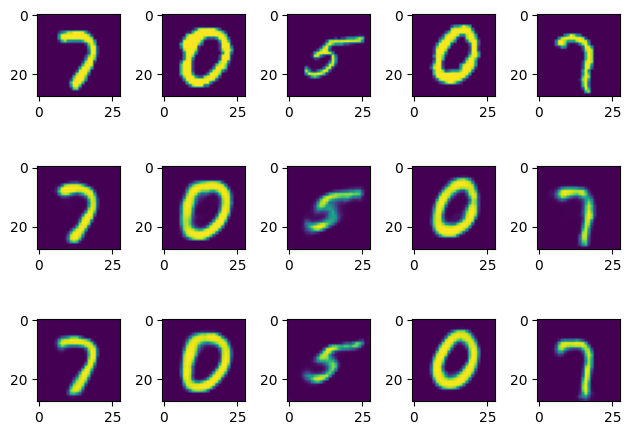

In [ ]:
import random
fig, (row1, row2, row3) = plt.subplots(3, 5)

for i in range(5):
    x = dev_dataset[random.randint(0,10000-1)][0].cuda()
    x_pred_linear = encoder_linear.forward(x, detach=True).view(28,28)
    x_pred_conv = encoder_conv.forward(x, detach=True).view(28,28)

    row1[i].imshow(x.cpu())
    row2[i].imshow(x_pred_linear.cpu())
    row3[i].imshow(x_pred_conv.cpu())

plt.tight_layout()
plt.show()

## Question 2c

### Training Functions

In [ ]:
def train_baseline(model: BaselineClassifier, criterion: nn.Module, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    prev_loss = 2000000000
    # epoch loop
    for epoch in range(num_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        train_total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            train_total_loss += criterion(pred_y, y).item()
            total_num += 1
            # backward pass
            for y_i in y:
                model.w[y_i] += 1
        print(f'{train_total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')
        # 
        # check convergence
        # 
        if abs(train_total_loss - prev_loss) < 1:
            return
        prev_loss = train_total_loss

In [ ]:
def train_classifier(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer,
                     encoder: nn.Module, max_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    prev_loss = 2000000000
    # epoch loop
    for epoch in range(max_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        train_total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            z = encoder.forward(x).detach()
            pred_y = model.forward(z)
            # calculate gradients
            loss = criterion(pred_y, y)
            loss.backward()
            # update statistics
            train_total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{train_total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            z = encoder.forward(x).detach()
            pred_y = model.forward(z)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')
        # 
        # check convergence
        # 
        if abs(train_total_loss - prev_loss) < 1:
            return
        prev_loss = train_total_loss

### Training

In [ ]:
classifier_base = BaselineClassifier().cuda()
train_baseline(classifier_base, nn.CrossEntropyLoss(), 100)

             Train       Test   
Epoch 1    

 2.34987    2.34765  
Epoch 2     2.34925    2.34765  


In [ ]:
classifier_linear = LinearClassifier().cuda()
train_classifier(classifier_linear, nn.CrossEntropyLoss(), optim.Adam(classifier_linear.parameters(), lr=0.001),
                 encoder_conv, 100)

             Train       Test   
Epoch 1    

 0.45963    0.24761  
Epoch 2     0.23480    0.21799  
Epoch 3     0.19633    0.18396  
Epoch 4     0.17417    0.17431  
Epoch 5     0.15833    0.16279  
Epoch 6     0.14545    0.15677  
Epoch 7     0.13760    0.15506  
Epoch 8     0.13108    0.15267  
Epoch 9     0.12579    0.14905  
Epoch 10    0.11921    0.15108  
Epoch 11    0.11430    0.15697  
Epoch 12    0.10946    0.14343  
Epoch 13    0.10643    0.15492  
Epoch 14    0.10249    0.15404  
Epoch 15    0.09882    0.16519  
Epoch 16    0.09386    0.14860  
Epoch 17    0.09187    0.14295  


## Question 3

### Training Function

In [11]:
def joint_training(model: JointModel, criterion: nn.Module, crit_encoder: nn.Module, optimizer: optim.Optimizer, max_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    prev_loss = 2000000000
    # epoch loop
    for epoch in range(max_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        train_total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            z = model.autoencoder.forward(x)
            pred_y = model.classifier.forward(z)
            # calculate gradients
            classifier_loss = criterion(pred_y, y)
            encoder_loss = crit_encoder(z, x)
            loss = classifier_loss + encoder_loss
            loss.backward()
            # update statistics
            train_total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{train_total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')
        # 
        # check convergence
        # 
        if abs(train_total_loss - prev_loss) < 1:
            return
        prev_loss = train_total_loss

### Training

In [12]:
joint_model = JointModel().cuda()
joint_training(joint_model, nn.CrossEntropyLoss(), nn.BCELoss(), optim.Adam(joint_model.parameters(), lr=0.001), 100)

             Train       Test   
Epoch 1     1.68298    0.78595  
Epoch 2     0.73578    0.32804  
Epoch 3     0.52998    0.28162  
Epoch 4     0.45040    0.19897  
Epoch 5     0.39743    0.22774  
Epoch 6     0.36127    0.16940  
Epoch 7     0.33680    0.13564  
Epoch 8     0.31673    0.15206  
Epoch 9     0.30286    0.13783  
Epoch 10    0.29033    0.12765  
Epoch 11    0.27986    0.13740  
Epoch 12    0.27287    0.12653  
Epoch 13    0.26616    0.15826  
Epoch 14    0.25987    0.14035  
Epoch 15    0.25678    0.13788  
Epoch 16    0.25299    0.13206  
Epoch 17    0.24064    0.13918  
Epoch 18    0.24178    0.13366  


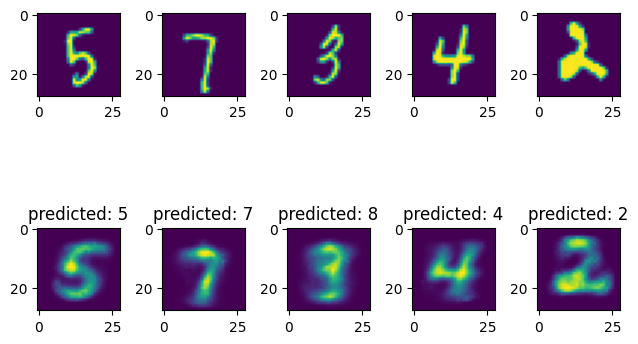

In [14]:
import random
fig, (row1, row2) = plt.subplots(2, 5)

with torch.no_grad():
    for i in range(5):
        x = dev_dataset[random.randint(0,10000-1)][0].cuda()
        z = joint_model.autoencoder.forward(x)
        y_pred = joint_model.forward(z).argmax().item()

        row1[i].imshow(x.cpu())
        row2[i].imshow(z.cpu().view(28,28))
        row2[i].set_title(f'predicted: {y_pred}')

plt.tight_layout()
plt.show()